In [1]:
%matplotlib inline
from matplotlib import style, dates
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, and_, or_

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)

In [11]:
m_columns = inspector.get_columns("Measurement")
s_columns = inspector.get_columns("Station")

In [12]:
for column in m_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
for column in s_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
splitted_last_date = last_date[0].split("-")
year_of_last_date = int(splitted_last_date[0])
month_of_last_date = int(splitted_last_date[1])
day_of_last_date = int(splitted_last_date[2])

In [15]:
formatted_last_date = dt.date(year_of_last_date,month_of_last_date,day_of_last_date)
formatted_begin_date = formatted_last_date - dt.timedelta(days=365)
year_of_begin_date = formatted_begin_date.strftime("%Y")
month_of_begin_date = formatted_begin_date.strftime("%m")
day_of_begin_date = formatted_begin_date.strftime("%d")
begin_date = f"{year_of_begin_date}-{month_of_begin_date}-{day_of_begin_date}"
begin_date

'2016-08-23'

In [16]:
# Perform a query to retrieve the data and precipitation scores
stmt = session.query(Measurement).\
    filter(Measurement.date>=begin_date).order_by(Measurement.date).statement

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df = pd.read_sql_query(stmt, session.bind)
df = df.dropna()
df_short = df[["date","prcp"]]
df_short_groupedby = df_short.groupby("date").max()
df_short_groupedby.head()

,prcp
date,
2016-08-23,1.79
2016-08-24,2.28
2016-08-25,0.21
2016-08-26,0.04
2016-08-27,0.18


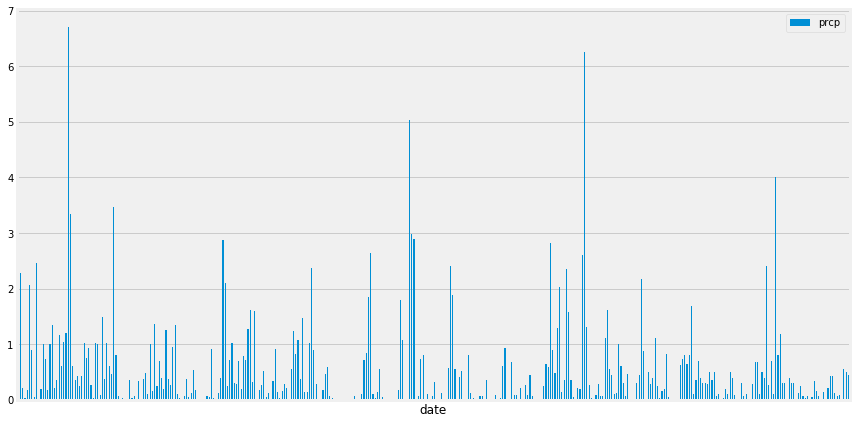

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
df_short_groupedby.plot(kind="bar",figsize=(12,6))
plt.gca().xaxis.set_major_locator(dates.MonthLocator())
plt.tight_layout()
plt.savefig("../results/precipitation.png")
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_statistics = df[["prcp"]].describe()
prcp_statistics

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station=="USC00519281").all()


[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [23]:
# Choose the station with the highest number of temperature observations.
session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

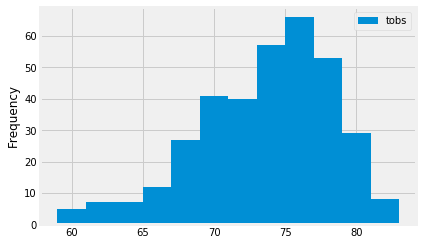

In [24]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stmt2 = session.query(Measurement).\
    filter(and_(Measurement.station=="USC00519281", Measurement.date>=begin_date)).order_by(Measurement.date).statement
df2 = pd.read_sql_query(stmt2, session.bind)
df2.dropna()
df2["tobs"].plot.hist(bins=12,legend="tobs")
plt.savefig("../results/temp_histogram.png")
plt.show()